In [1]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from ttjjana import prepdata

from flowmatching import *

# Read data and reshape

In [2]:
rawinputs, normedinputs, inputmeans, inputsigma, ncat_per_feature = prepdata()

In [3]:
# this contains how many conditional features are in each category
ncat_per_feature

[0, 0, 0, 0, 3, 2]

In [4]:
normedinputs.shape

(227376, 9)

In [5]:
issignal = (rawinputs['njet']>=9) & (rawinputs['nbtag']>=3) # signal_selection 
isbackground = ~issignal
bkgnormed = normedinputs[isbackground]
bkg = rawinputs[isbackground]
xmax = np.reshape(inputmeans + 5* inputsigma, inputmeans.shape[1])

In [6]:
featurevars = ['met', 'ht', 'pt5', 'pt6', 'njet', 'nbtag']

In [7]:
#conditional dimensions
cdim = np.sum(ncat_per_feature)
M = normedinputs.shape[1] - cdim
if cdim > 0:
    print(f"Conditional dimension: {cdim}")
    isconditional = True
else:
    print("No conditional dimension")
    isconditional = False

config = Config(
        M=M,
        nhidden=256,        # Reduced hidden size for faster example
        nlayers=3,          # Number of layers (tune)
        batch_size=128,    # Adjust based on VRAM
        learning_rate=1e-3, # Tune learning rate
        epochs=200,         # Number of training epochs
        time_embed_dim=64, # Dimension for time embedding
        ode_steps=25,       # Number of steps for sampling ODE solver
        epsilon=1e-5,        # Small offset for time sampling
        conditional=isconditional,   # Enable conditional training
        conditional_dim=cdim    # Dimension of conditional variable
    )

Conditional dimension: 5
Using device: cuda
Automatic Mixed Precision (AMP) enabled: True


In [8]:
data_cpu = torch.from_numpy(bkgnormed).float()

# 3. Move Entire Dataset to Target Device (GPU if available)
data_on_device = None
if config.device.type == 'cuda':
    print(f"Attempting to move dataset ({data_cpu.nelement() * data_cpu.element_size() / 1024**2:.2f} MB) to {config.device}...")
    try:
        data_on_device = data_cpu.to(config.device)
        print(f"Successfully moved dataset to {data_on_device.device}")
    except RuntimeError as e:
        print(f"\n----- ERROR moving full dataset to GPU: {e}. Exiting. -----")
        exit()
else:
    print("Running on CPU, keeping data on CPU.")
    data_on_device = data_cpu


Attempting to move dataset (6.95 MB) to cuda...
Successfully moved dataset to cuda:0


# Train model

In [9]:
# --- Training ---
train_model_flag = True
config_dir = get_config_directory(config)
pathlib.Path(config_dir).mkdir(parents=True, exist_ok=True)
#os.makedirs(config_dir, exist_ok=True)
model_filename = "model_fm.pth" # Flow Matching model filename

if train_model_flag:
    print("\n--- Starting Flow Matching Training ---")
    # Call the flow matching training function
    trained_model, epoch_losses = train_flow_matching(data_on_device, config)

    if trained_model:
        save_model(trained_model, config, filename=model_filename)
        if epoch_losses:
            plt.figure(figsize=(10, 5))
            plt.plot(epoch_losses, label='Training Loss (Flow Matching)')
            plt.xlabel('Epoch')
            plt.ylabel('Loss (MSE)')
            plt.yscale('log')
            plt.grid(True, which='both', linestyle='--', linewidth=0.5)
            plt.legend()
            plt.title(f'Flow Matching Training Loss\n{get_config_description(config)}')
            loss_fig = plt.gcf()
            save_plot(loss_fig, config, "training_loss_fm.png")
    else:
        print("Training failed, model not saved.")
else:
    #model_path = os.path.join(config_dir, model_filename)
    model_path = pathlib.Path(config_dir) / model_filename
    #if not os.path.exists(model_path):
    if not model_path.exists():
        print(f"\nModel file {model_path} not found. Cannot perform sampling.")
    else:
        print("\n--- Loading Model for Flow Matching Sampling ---")
        # Load the velocity network model
        trained_model = load_model(VelocityMLP, config, filename=model_filename)


--- Starting Flow Matching Training ---
Training Flow Matching model with data on device: cuda:0
DataLoader created with batch size 128, num_workers=0, pin_memory=False
Initialized VelocityMLP with 3 layers, hidden size 256, time_embed_dim 64, conditional True, conditional_dim 5
Starting Flow Matching training on cuda for 200 epochs...


Training FM (Epochs): 100%|██████████| 200/200 [32:09<00:00,  9.65s/epoch, avg_loss=1.175701]



Training finished.
Model saved to FM_M4_nh256_nl3_ted64_BS128_LR1e-03_E200\model_fm.pth
Plot saved to FM_M4_nh256_nl3_ted64_BS128_LR1e-03_E200\training_loss_fm.png


In [10]:
condlist = [
            [[1., 0., 0.,   1., 0., ]],
            [[0., 1., 0.,   1., 0., ]],
            [[0., 0., 1.,   1., 0., ]],
            [[1., 0., 0.,   0., 1., ]],
            [[0., 1., 0.,   0., 1., ]],
            [[0., 0., 1.,   0., 1., ]]
        ]
select0 = (rawinputs['njet']==7) & (rawinputs['nbtag']==2)
select1 = (rawinputs['njet']==8) & (rawinputs['nbtag']==2)
select2 = (rawinputs['njet']>=9) & (rawinputs['nbtag']==2)
select3 = (rawinputs['njet']==7) & (rawinputs['nbtag']>=3)
select4 = (rawinputs['njet']==8) & (rawinputs['nbtag']>=3)
select5 = (rawinputs['njet']>=9) & (rawinputs['nbtag']>=3)
select_data = [select0, select1, select2, select3, select4, select5]

plottextlist=[
    f'$N_j=7, N_b=2$',
    f'$N_j=8, N_b=2$',
    f'$N_j\geq 9, N_b=2$',
    f'$N_j=7, N_b\geq 3$',
    f'$N_j=8, N_b\geq 3$',
    f'$N_j\geq 9, N_b\geq 3$'
]
njlist = [7, 8, 9, 7, 8, 9]
nblist = [2, 2, 2, 3, 3, 3]

In [11]:
cond = torch.tensor(condlist[0]*4000).to(config.device).float()

In [12]:
cond

tensor([[1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0.],
        ...,
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0.]], device='cuda:0')

In [13]:
gensamples = sample_flow(trained_model, config, 4000, cond)

Starting ODE integration with 25 steps...
ODE integration finished.


In [14]:
gensamples.shape

torch.Size([4000, 4])

(array([[8.15273445e-01, 8.59993086e-01, 7.44754136e-01, 6.93154427e-01,
         5.67595437e-01, 4.16236654e-01, 3.33677345e-01, 2.63157884e-01,
         1.85758507e-01, 1.53078769e-01, 1.15239074e-01, 8.25593636e-02,
         9.11592369e-02, 4.81596288e-02, 5.15995681e-02, 2.75197879e-02,
         2.57998011e-02, 1.54798704e-02, 1.71998560e-02, 8.59993940e-03,
         6.87994241e-03, 3.43997120e-03, 5.15995681e-03, 5.15996364e-03,
         3.43997120e-03, 6.87994241e-03, 1.71998788e-03, 1.71998560e-03,
         0.00000000e+00, 0.00000000e+00, 1.71998788e-03, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 1.71998332e-03, 1.71998788e-03,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
         0.00000000e+00, 0.00000000e+00],
        [8.13181939e-01, 8.49575341e-01, 7.77544612e-01, 6.51409490e-01,
         

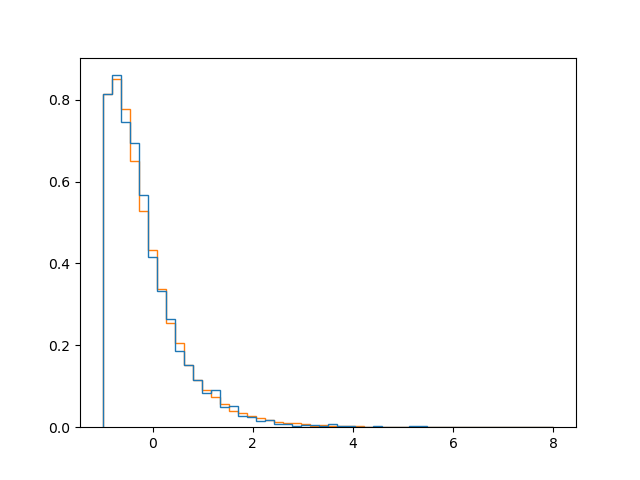

In [15]:
%matplotlib widget
plt.hist((gensamples[:,2],normedinputs[select0][:,2]), bins=50, density=True, range=(-1, 8), histtype='step', label='Flow Matching')

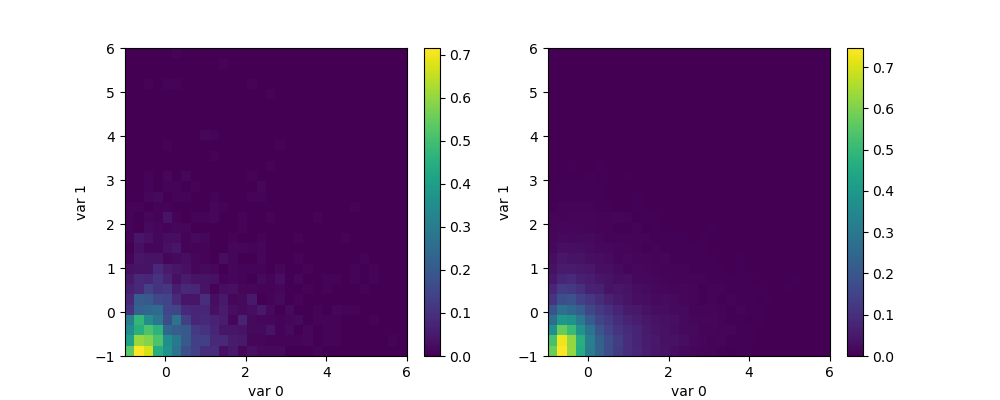

In [16]:
plt.close()
fig, ax = plt.subplots(1, 2 ,figsize=(10, 4))
plt.sca(ax[0])
plt.hist2d(gensamples[:,0],gensamples[:,1], bins=30, range=((-1, 6), (-1,6)), density=True)
plt.xlabel('var 0')
plt.ylabel('var 1')    
plt.colorbar()
plt.sca(ax[1])
plt.hist2d(normedinputs[select0][:,0],normedinputs[select0][:,1], bins=30, range=((-1, 6), (-1, 6)), density=True)
plt.xlabel('var 0')
plt.ylabel('var 1')
plt.colorbar()
plt.show()

# Create fake data list

In [17]:
fakedatalist = []
for cond, nj, nb in zip(condlist, njlist, nblist):
        condtorch = torch.tensor(cond*4000).to(config.device).float()
        fakedata = sample_flow(trained_model, config, 4000, condtorch).cpu().numpy()

        # all data
        fakedata = fakedata * inputsigma[:, :config.M] + inputmeans[:, :config.M]
        nfakes = fakedata.shape[0]

        fakedata = np.hstack((fakedata, np.array([nj]*nfakes).reshape((nfakes,1))\
                , np.array([nb]*nfakes).reshape(nfakes,1) )
        )
        fakedatalist.append(fakedata)


Starting ODE integration with 25 steps...
ODE integration finished.
Starting ODE integration with 25 steps...
ODE integration finished.
Starting ODE integration with 25 steps...
ODE integration finished.
Starting ODE integration with 25 steps...
ODE integration finished.
Starting ODE integration with 25 steps...
ODE integration finished.
Starting ODE integration with 25 steps...
ODE integration finished.


# Plot

In [ ]:

ncol=3
labelsindices = [['MET', 'met', 0.0, xmax[0]], ['H_T', 'ht', 0.0, xmax[1]],\
    ['p_{T5}', 'pt5', 0.0, xmax[2]], ['p_{T6}', 'pt6', 0.0, xmax[3]]]
nbins=20
runplots = True
if runplots:
    yscales = ['log', 'linear']
    for yscale in yscales:
        for li in labelsindices:
            pos = featurevars.index(li[1])
            fig, ax = plt.subplots(2,ncol, figsize=(3*ncol,6))
            iplot = 0
            for fakedata, seld, plottext in zip(fakedatalist, select_data, plottextlist):
                input_data = rawinputs[seld]

                # make matrix of plots
                row = iplot // ncol
                col = iplot % ncol
                iplot += 1
                plt.sca(ax[row,col])
                plt.yscale(yscale)
                plt.xlabel(f"${li[0]}$ (GeV)")
                plt.hist(input_data[li[1]], bins=nbins, alpha=0.5, range=(li[2], li[3]), density=True, label='Data')
                plt.hist(fakedata[:,pos], bins=nbins, alpha=0.5, range=(li[2], li[3]), density=True, label='Flow Matching')
                #plt.hist(bkg[li[1]], bins=nbins, alpha=0.5, range=(li[2], li[3]), histtype='step', normed=True)
                plt.text(0.6, 0.8, plottext, transform=ax[row,col].transAxes, fontsize=10)
        
            fig.tight_layout()
            #fig.savefig(os.path.join(savedir, f'result_matrix_{li[1]}_{yscale}.pdf'))
            fig.savefig(pathlib.Path(config_dir) / f'result_matrix_{li[1]}_{yscale}.pdf')
            plt.close(fig)